***`Universidad de Sonora, Campus Hermosillo`***

---

***`Profesor: `*** *`Lizarraga Celaya Carlos`*

***`Materia: `*** *`Física Computacional`*

---

***`Trabajo: `*** *`Evaluación 1`*

---

***`Alumno: `*** *`Bonillas Miranda Akin`*

***`Número de Expediente: `*** *`219211360`*

***`Correo: `*** *`a219211360@unison.mx // akinbonillasmiranda@gmail.com`*

***`Número Telefónico: `*** *`662 368 2474`*

---

***`Grupo: `*** *`2`*

***`Carrera: `*** *`Licenciatura en Física`*

***`Semestre: `*** *`Cuarto Semestre`*

---

***`Miércoles 24 de Febrero de 2021, Hermosillo, Sonora`***

#***`Parte 1.`*** *`Construcción de una Serie de Tiempo. `*

*`Selecciona una serie de tiempo de uno de los cuatro observatorios. Con este archivo de datos se pide transformarlo en una serie de tiempo de las concentraciones de CO2. `*

In [244]:
#========================== IMPORTAMOS LAS BIBLIOTECAS =========================

import pandas as pd             # Importamos Pandas 
import numpy as np              # Importamos NumPy
import matplotlib.pyplot as plt # Importamos Mmatplotlib
import seaborn as sns           # Importamos Seaborn

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [245]:
#================= INTRODUCIMOS EL URL Y DEFINIMOS LAS COLUMNAS ================

URL = "https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt"

cols = [ "site_code", "year", "month", "day", "hour", "minute", "second", "time_decimal", "value", "value_std_dev", "nvalue", "latitude", "longitude", "altitude", "elevation", "intake_height", "qcflag" ]


#============================ GENERAMOS EL DATAFRAME ===========================

df_data = pd.read_csv( URL, names=cols, encoding="cp1251", sep="\s+", header=None, skiprows=151, skipfooter=0, engine="python" )

df_data.head() # Comprobamos los datos

,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
0,SPO,1975,1,1,0,0,0,1975.000000,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
1,SPO,1975,1,2,0,0,0,1975.002740,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
2,SPO,1975,1,3,0,0,0,1975.005479,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
3,SPO,1975,1,4,0,0,0,1975.008219,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
4,SPO,1975,1,5,0,0,0,1975.010959,-999.99,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..


In [194]:
#=================== REEMPLAZAMOS LOS DATOS FALTANTES POR NaN ==================

df_modi0 = df_data.copy() # Hacemos una copia del DataFrame original

null = -999.99
df_modi1 = df_modi0.replace( to_replace=null, value="NaN", regex=True )

df_modi1.head()

,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
0,SPO,1975,1,1,0,0,0,1975.000000,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
1,SPO,1975,1,2,0,0,0,1975.002740,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
2,SPO,1975,1,3,0,0,0,1975.005479,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
3,SPO,1975,1,4,0,0,0,1975.008219,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..
4,SPO,1975,1,5,0,0,0,1975.010959,NaN,-99.99,0,-89.98,-24.8,2820.0,2810.0,10.0,*..


In [195]:
#========================= CONSTRUIMOS LA COLUMNA FECHA ========================

df_modi2 = df_modi1.copy()
df_modi2 = pd.DataFrame(df_modi1,columns=[ "day", "month", "year" ])

df_modi2[ "date" ] = pd.to_datetime( df_modi2 )

df_modi2.head()

df_modi3 = pd.DataFrame( df_modi2, columns=[ "date" ] )
df_modi3[ "value" ] = df_modi1[ "value" ] 

df_modi3.head()

,date,value
0,1975-01-01,NaN
1,1975-01-02,NaN
2,1975-01-03,NaN
3,1975-01-04,NaN
4,1975-01-05,NaN


In [196]:
#=========================== DATOS DESDE 1980 A 2019 ===========================

df_CO2 = df_modi3.copy() # Guardamos los datos en un nuevo DataFrame

df_CO2 = df_CO2.set_index( "date" ) # Indice "date"

start, end = "1980-01", "2019-12" # Periodo solicitado

df_CO2_loc = df_CO2. loc[ start:end ].copy() # Limitamos los datos al periodo
ts_CO2 = df_CO2_loc[ "value" ]
ts_CO2 = ts_CO2.astype(float) # Se convierten los datos en flotantes

ts_CO2.ffill ( axis=0, inplace=True )

print(ts_CO2.head())
print(ts_CO2.tail())


date
1980-01-01    336.30
1980-01-02    336.28
1980-01-03    336.21
1980-01-04    336.19
1980-01-05    336.20
Name: value, dtype: float64
date
2019-12-27    409.06
2019-12-28    409.00
2019-12-29    408.70
2019-12-30    408.41
2019-12-31    408.57
Name: value, dtype: float64


# ***`Parte 2.`*** *`Análisis de la Serie de Tiempo.`*

In [197]:
#==================== Prueba Aumentada de Dickey-Fuller(ADF) ===================
   
def ADF(df_cp):
    
    #Determinar la Estadística de promedios móviles
    rollmean = df_cp.rolling( window=365, center=True ).mean()
    rollstd = df_cp.rolling( window=365, center=True ).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (18,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot( df_cp, color="black", markersize=5, label="Original" )
    plt.plot( rollmean, color="red", markersize=5,label="Promedio Móvil" )
    plt.plot( rollstd, color="blue", markersize=5,label = "Desviación STD Móvil" )
 
    plt.legend( loc="best" )
    plt.title( "Promedio Móvil y Desviación Estándar" )
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print( "Resultados de la Prueba de Dickey-Fuller:" )
    print( " " )
    dftest = adfuller( df_cp, autolag="AIC" )
    dfoutput = pd.Series( dftest[0:4], index=["Estadística de prueba: ", "Valor p: ", "#Retrasos utilizados: ", "N° de Observaciones: "] )

    for key,value in dftest[4].items():
        dfoutput[ "Valor crítico (%s):" %key ] = value

    print( dfoutput )

# *`Proceso de estacionalización: Transformación logarítmica + Método de descomposición`*

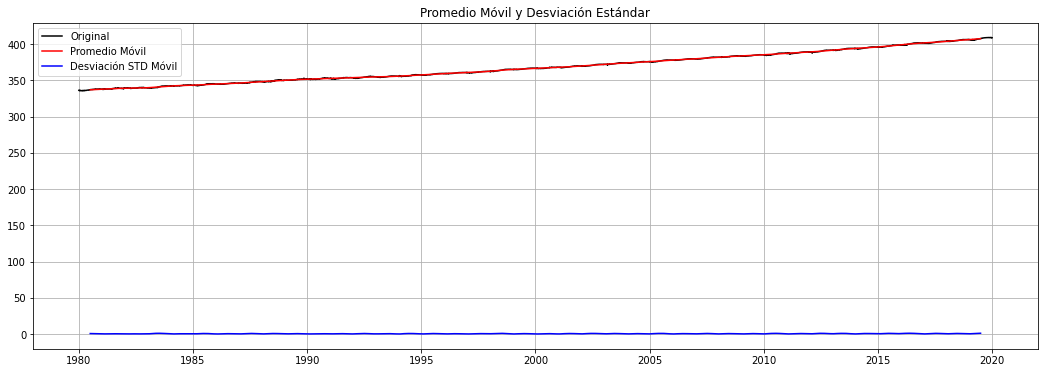

Resultados de la Prueba de Dickey-Fuller:
 
Estadística de prueba:         0.973933
Valor p:                       0.993983
#Retrasos utilizados:         42.000000
N° de Observaciones:       14567.000000
Valor crítico (1%):           -3.430799
Valor crítico (5%):           -2.861738
Valor crítico (10%):          -2.566876
dtype: float64


In [238]:
#===================== APLICAMOS LA PRUEBA ADF A NUESTRO DF ====================

ADF(ts_CO2)

*`Tras aplicar la prueba ADF al DataFrame de los datos de CO2 desde 1980 a 2019 podemos apreciar en los resultados que el valor de p es absurdamente grande comparado con el valor que estamos buscando ( ~99.40% > 5% ), por lo que el paso siguiente es aplicar una transformación logarítmica.`*

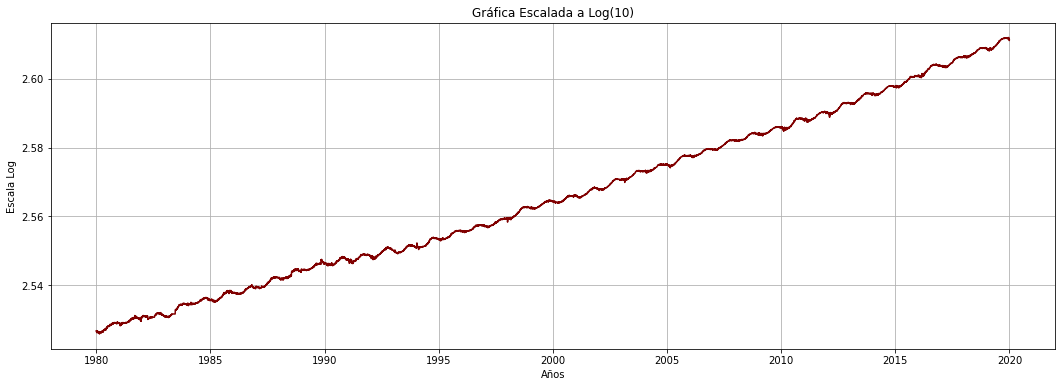

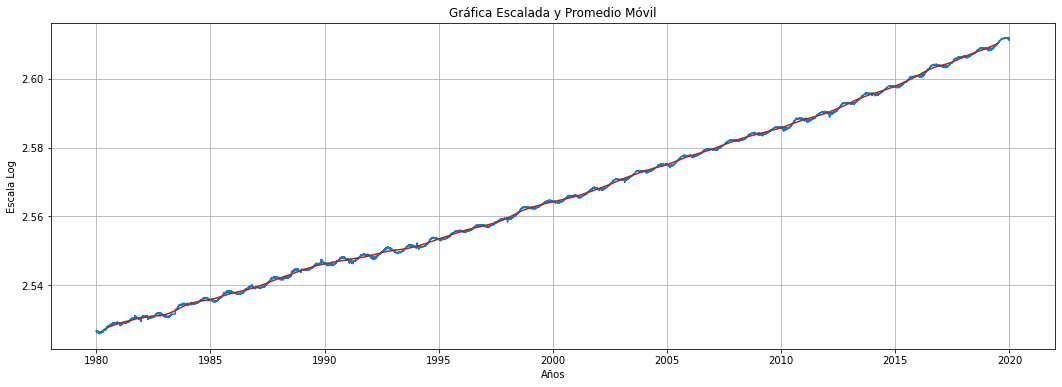

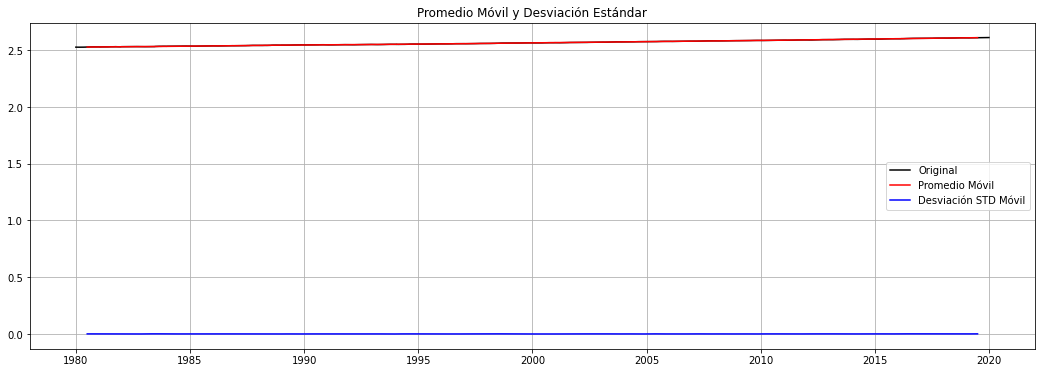

Resultados de la Prueba de Dickey-Fuller:
 
Estadística de prueba:         0.538071
Valor p:                       0.985985
#Retrasos utilizados:         42.000000
N° de Observaciones:       14567.000000
Valor crítico (1%):           -3.430799
Valor crítico (5%):           -2.861738
Valor crítico (10%):          -2.566876
dtype: float64


In [239]:
#================== Seleccionamos la función log y graficamos ==================

ts_logCO2 = np.log10( ts_CO2 )
plt.plot( ts_logCO2, color="maroon" )

plt.xlabel( "Años", color="black" )
plt.ylabel( "Escala Log", color="black" )
plt.title( "Gráfica Escalada a Log(10)" )

plt.grid()
plt.show();

#=================== Calculamos el Promedio móvil a 365 días ===================

meanlogCO2 = ts_logCO2.rolling( 365, center=True ).mean()
plt.plot( ts_logCO2 )

plt.plot( meanlogCO2, color = "brown" )

plt.xlabel( "Años", color="black" )
plt.ylabel( "Escala Log", color="black" )
plt.title( "Gráfica Escalada y Promedio Móvil" )

plt.grid()
plt.show();



#ts_logmovCO2_diff = ts_logCO2 - meanlogCO2
# cp_logmovTmax_diff.head()

#ts_logmovCO2_diff.dropna( inplace=True )
# cp_logmovTmax_diff.head()

#============== Aplicamos la Prueba ADF a la nueva serie de tiempo =============

ADF(ts_logCO2)

Tras aplicar la tranformación logarítmica a los datos no se pudo apreciar ninguna mejoría significativa, pues el valor de p obtenido es practicamente igual al de antes (98.60% > 5%).

In [240]:
def decomp(dt_data):
  #======== Método de descomposición usando la biblioteca statsmodels.tsa ========

  decomp = sm.tsa.seasonal_decompose( dt_data.interpolate(), model="additive", freq=365 )

  # La función regresa 3 componentes: tendencia, estacionalidad y un residuo

  Trend = decomp.trend
  Stati = decomp.seasonal
  Resid = decomp.resid

  # Graficamos las componentes
  plt.rcParams[ "figure.figsize" ] = (12,12)
  plt.subplot( 411 )
  plt.plot( dt_data, label="Observado (Escala Log)" )
  plt.legend( loc="best" )

  plt.subplot( 412 )
  plt.plot( Trend, label="Tendencia" )
  plt.legend( loc="best" )

  plt.subplot( 413 )
  plt.plot( Stati, label="Estacionalidad" )
  plt.legend( loc="best" )

  plt.subplot( 414 )
  plt.plot( Resid, label="Residuo" )
  plt.legend( loc="best" )

  # Colocar gráficas lo más cercanas posibles
  plt.tight_layout();

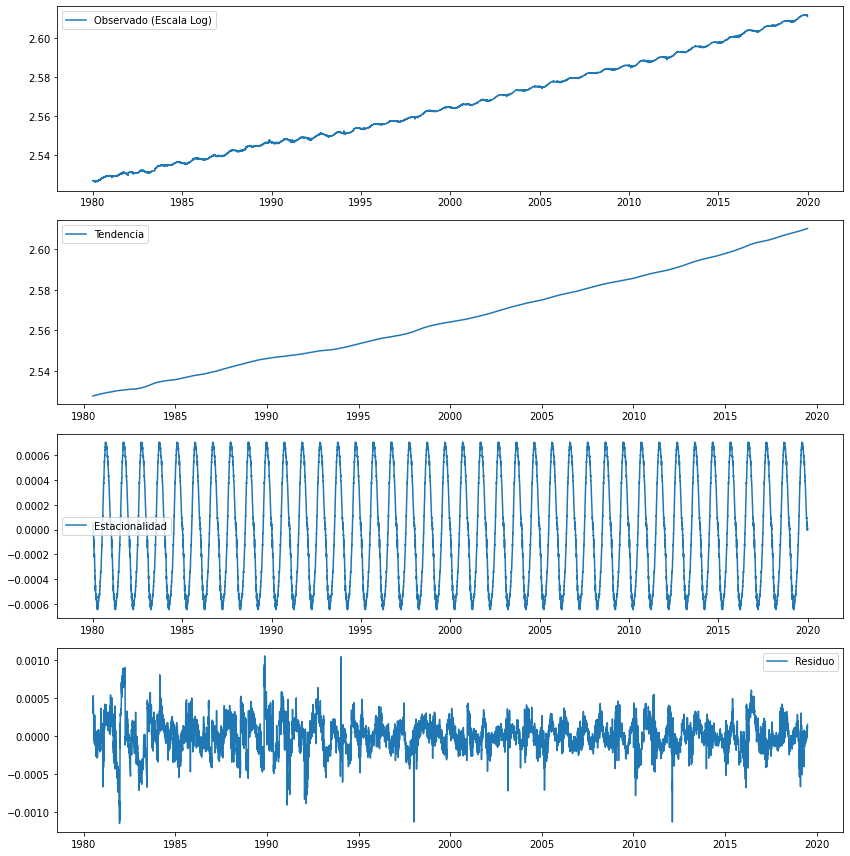

In [241]:
#=========================== Descomponemos los datos ===========================

decomp(ts_logCO2)

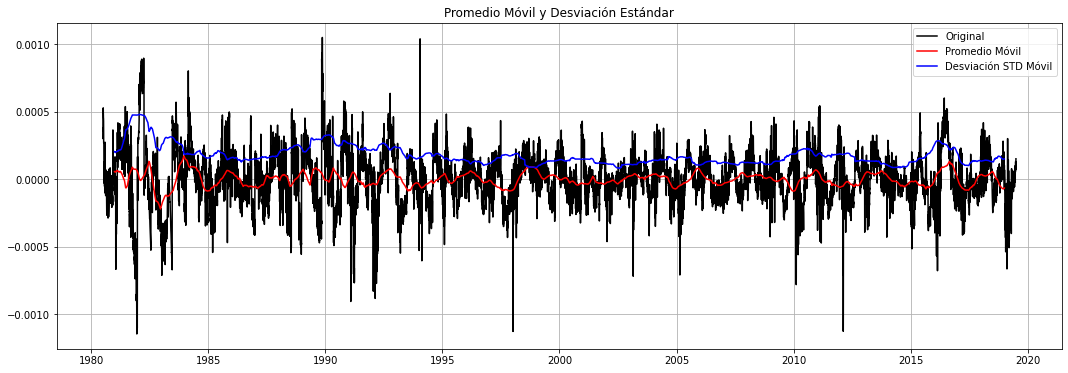

Resultados de la Prueba de Dickey-Fuller:
 
Estadística de prueba:    -1.135572e+01
Valor p:                   9.746288e-21
#Retrasos utilizados:      2.800000e+01
N° de Observaciones:       1.421700e+04
Valor crítico (1%):       -3.430810e+00
Valor crítico (5%):       -2.861743e+00
Valor crítico (10%):      -2.566878e+00
dtype: float64


In [242]:
#=================== Eliminando la Tendencia y Estacionalidad ==================

decomp = sm.tsa.seasonal_decompose( ts_logCO2.interpolate(), model="additive", freq=365 )
Resid = decomp.resid

ts_logCO2_decomp = Resid 
ts_logCO2_decomp.dropna( inplace=True )
ADF( ts_logCO2_decomp )

*`Una vez aplicado el método de descomposición conseguimos un valor considerable para p es cuál es 9.746288e-21 el cuál es mucho menor que 0.05`*

*`Tras finalmente haber aplicado la diferenciación obtuvimos un valor aún mejor para p el cuál es 3.162027e-22`*

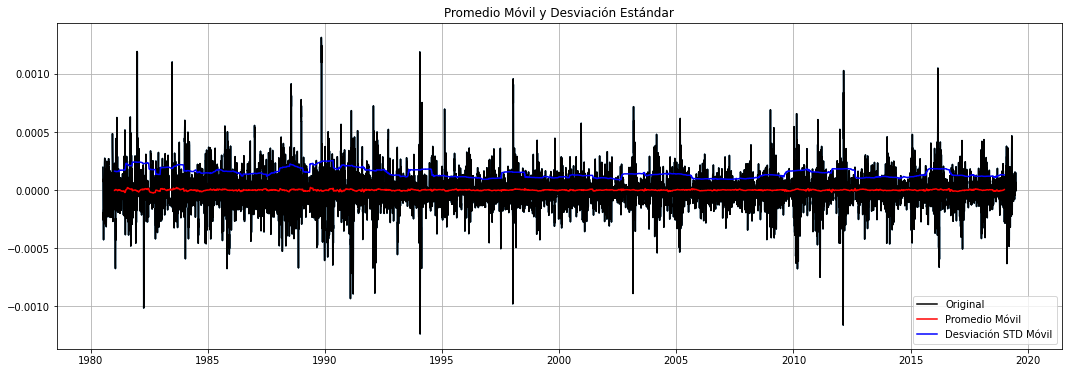

Resultados de la Prueba de Dickey-Fuller:
 
Estadística de prueba:       -20.730494
Valor p:                       0.000000
#Retrasos utilizados:         42.000000
N° de Observaciones:       14196.000000
Valor crítico (1%):           -3.430811
Valor crítico (5%):           -2.861744
Valor crítico (10%):          -2.566878
dtype: float64


In [243]:
#================== Diferenciamos usando la función df.shift() =================

ts_logCO2_decomp_diff = ts_logCO2_decomp - ts_logCO2_decomp.shift( periods=7 )
plt.plot( ts_logCO2_decomp_diff );

# Probamos la estacionaridad
ts_logCO2_decomp_diff.dropna( inplace=True )
ADF( ts_logCO2_decomp_diff )

*`Todo sea dicho, tras aplicar este último método, el cuál es el de diferenciación discreta hemos obtenido un valor para p tan pequeño que prácticamente es 0.`*

# *`Aplicamos el método ARIMA`*

q=6
p=2


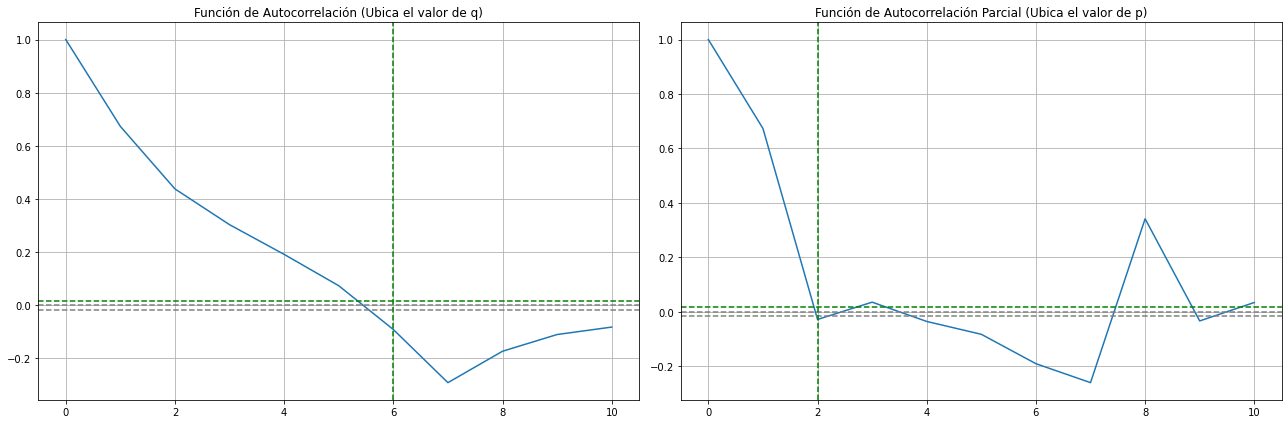

In [227]:
#=============================== Aplicamos ARIMA ===============================

lag_acf = acf( ts_logCO2_decomp_diff, nlags=10 )
lag_pacf = pacf( ts_logCO2_decomp_diff, nlags=10, method = "ols" )

# Tamaño de las gráficas
plt.rcParams[ "figure.figsize" ] = ( 18,6 )

#----------------- Gráfica de ACF (Función de Autocorrelación) -----------------

plt.subplot( 121 )
plt.plot( lag_acf )

plt.axhline( y=0, linestyle="--", color="gray" )
plt.axhline( y=-1.96/np.sqrt(len(ts_logCO2_decomp_diff)), linestyle="--", color="gray" )
plt.axhline( y=1.96/np.sqrt(len(ts_logCO2_decomp_diff)), linestyle="--", color="green" )

# Graficamos unas líneas verticales como referencias
plt.axvline( x=6, linestyle="--", color="green" )
plt.grid()
plt.title( "Función de Autocorrelación (Ubica el valor de q)" )
print( "q=6" )

#------------- Gráfica de PACF (Función de Autocorrelación Parcial) ------------

plt.subplot( 122 )
plt.plot( lag_pacf )

plt.axhline( y=0, linestyle="--", color="gray" )
plt.axhline( y=-1.96/np.sqrt(len(ts_logCO2_decomp_diff)), linestyle="--", color="gray" )
plt.axhline( y=1.96/np.sqrt(len(ts_logCO2_decomp_diff)), linestyle="--", color="green" )

# Graficamos unas líneas verticales como referencias 
plt.axvline( x=2, linestyle='--', color="green" )
plt.grid()
plt.title( "Función de Autocorrelación Parcial (Ubica el valor de p)" )
print( "p=2" )

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 0)   Log Likelihood              116098.859
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232189.718
Time:                        06:35:07   BIC                        -232159.360
Sample:                    01-02-1980   HQIC                       -232179.632
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.788e-06   5.33e-07     10.851      0.000    4.74e-06    6.83e-06
ar.L1.D.value    -0.1522      0.008    -18.682      0.000      -0.168      -0.136
ar.L2.D.value    -0.1753      0.008    -

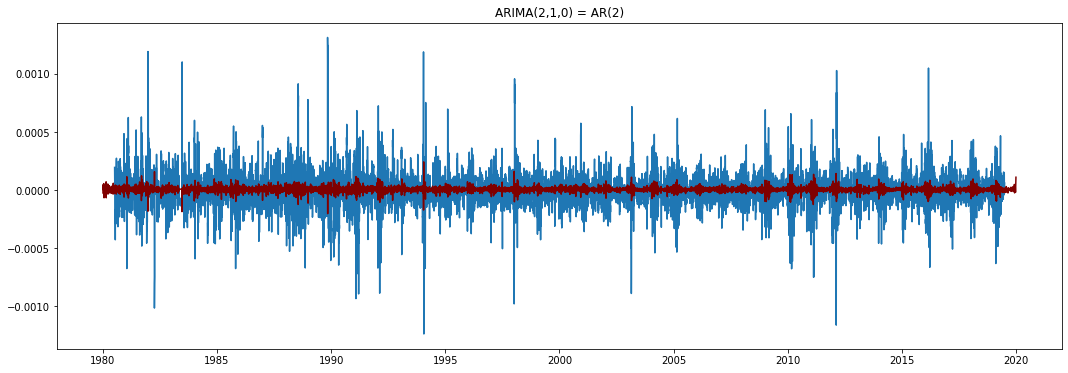

In [228]:
#======================= Modelo AR(p): (p,d,q) = (2,1,0) =======================

modelo = ARIMA( ts_logCO2, order=(2,1,0), missing="drop" )

results_AR = modelo.fit( displ=-1 )

plt.plot( ts_logCO2_decomp_diff )
plt.plot( results_AR.fittedvalues, color="maroon" )
plt.title("ARIMA(2,1,0) = AR(2)" )

print( results_AR.summary() )

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(0, 1, 6)   Log Likelihood              115820.123
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -231624.247
Time:                        06:36:10   BIC                        -231563.532
Sample:                    01-02-1980   HQIC                       -231604.076
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.815e-06   2.44e-07     23.850      0.000    5.34e-06    6.29e-06
ma.L1.D.value    -0.1786      0.009    -20.393      0.000      -0.196      -0.161
ma.L2.D.value    -0.2081      0.008    -

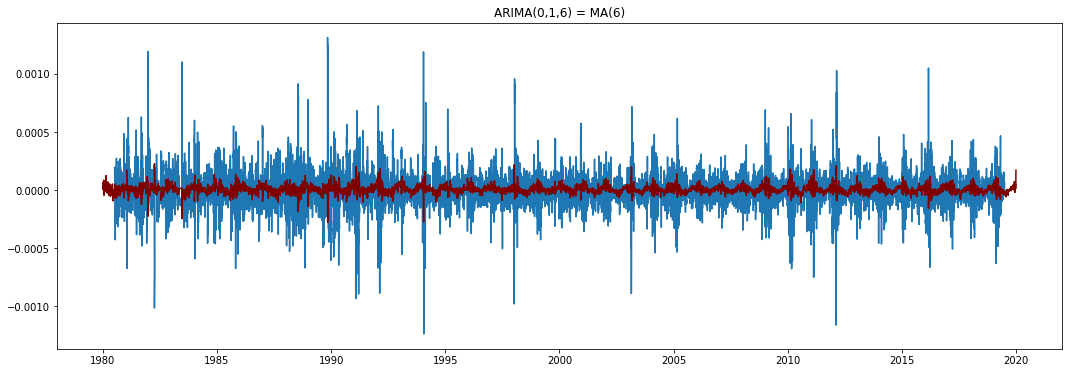

In [229]:
#======================= Modelo MA(q): (p,d,q) = (0,1,6) =======================

modelo = ARIMA( ts_logCO2, order=(0,1,6), missing="drop" )

results_MA = modelo.fit(displ=-1)

plt.plot( ts_logCO2_decomp_diff )
plt.plot( results_MA.fittedvalues, color="maroon" )
plt.title( "ARIMA(0,1,6) = MA(6)" )

print( results_MA.summary() )

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 6)   Log Likelihood              116209.927
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232399.855
Time:                        06:37:42   BIC                        -232323.961
Sample:                    01-02-1980   HQIC                       -232374.642
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.795e-06   4.18e-07     13.861      0.000    4.98e-06    6.61e-06
ar.L1.D.value     0.3648        nan        nan        nan         nan         nan
ar.L2.D.value    -0.6854      0.094     

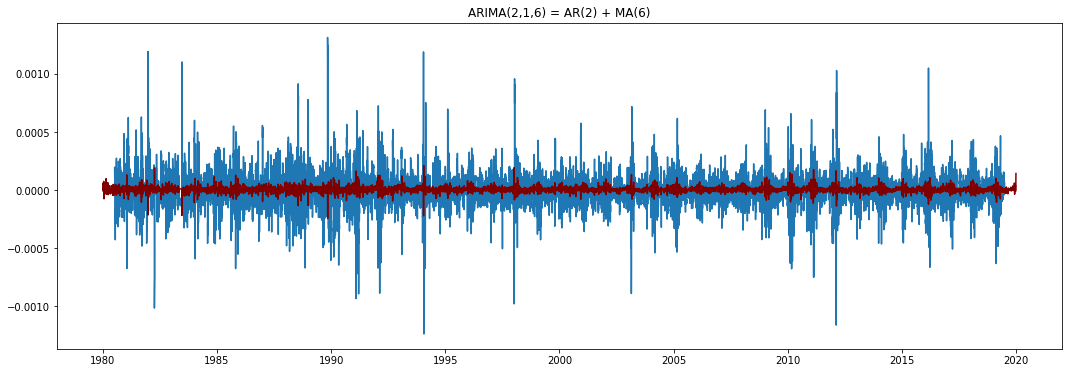

In [230]:
#====================== Modelo ARIMA(p): (p,d,q) = (2,1,6) =====================

modelo = ARIMA( ts_logCO2, order=(2,1,6), missing="drop" )

results_ARIMA = modelo.fit( displ=-1 )

plt.plot( ts_logCO2_decomp_diff )
plt.plot( results_ARIMA.fittedvalues, color="maroon" )
plt.title( "ARIMA(2,1,6) = AR(2) + MA(6)" )

print( results_ARIMA.summary() )

In [231]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA

predic_ARIMA_diff = pd.Series( results_ARIMA.fittedvalues, copy=True )
print( predic_ARIMA_diff )

# Le sumamos las predicciones de ARIMA a la serie observada (cp_logTmax)

predic_logARIMA = pd.Series( ts_logCO2, index = ts_logCO2.index )
predic_logARIMA = predic_logARIMA.add( predic_ARIMA_diff )

print( predic_logARIMA.head() )
print( predic_logARIMA.tail() )


date
1980-01-02    0.000006
1980-01-03    0.000010
1980-01-04    0.000026
1980-01-05    0.000032
1980-01-06    0.000022
                ...   
2019-12-27    0.000004
2019-12-28    0.000018
2019-12-29    0.000034
2019-12-30    0.000087
2019-12-31    0.000142
Length: 14609, dtype: float64
date
1980-01-01         NaN
1980-01-02    2.526707
1980-01-03    2.526621
1980-01-04    2.526611
1980-01-05    2.526630
dtype: float64
date
2019-12-27    2.611791
2019-12-28    2.611741
2019-12-29    2.611438
2019-12-30    2.611184
2019-12-31    2.611409
dtype: float64


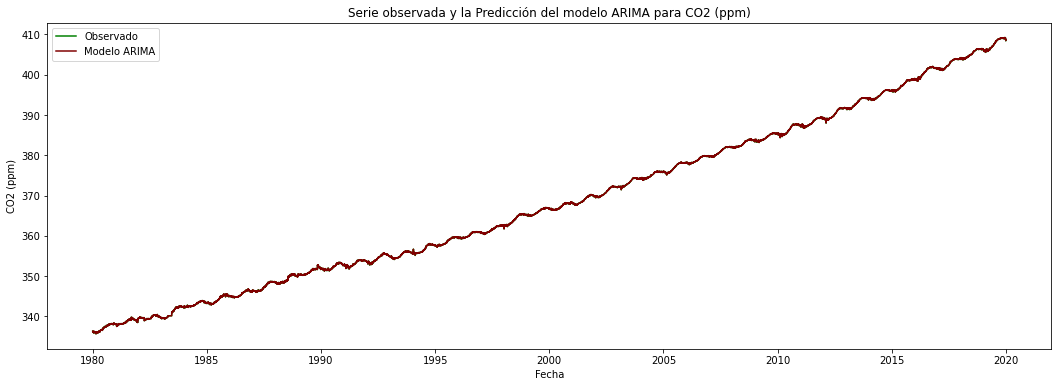

In [235]:
#======================== Graficamos serie y predicción ========================

predic_ARIMA = 10**( predic_logARIMA )

plt.rcParams["figure.figsize"] = ( 18,6 )

plt.plot( ts_CO2, label="Observado", color="green" );
plt.plot( predic_ARIMA, label="Modelo ARIMA", color="maroon" );
plt.xlabel( "Fecha" )
plt.ylabel( "CO2 (ppm)" )
plt.title( "Serie observada y la Predicción del modelo ARIMA para CO2 (ppm)" )

plt.legend( loc="best" );

In [236]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt( np.mean((predic_ARIMA - ts_CO2)**2) )
print( "RMSE:" , RMSE)

RMSE: 0.018899244271053547


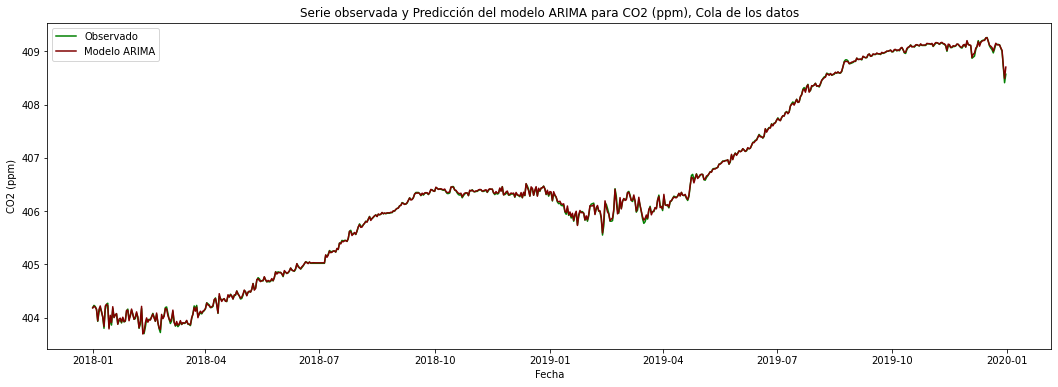

In [237]:
# Graficamos sólo los útimos datos de las series 

ts_CO2_last = ts_CO2.tail(730)

predic_ARIMA_last = predic_ARIMA.tail(730)

plt.plot( ts_CO2_last, label="Observado", color="green" );
plt.plot( predic_ARIMA_last, label="Modelo ARIMA", color="maroon" );
plt.xlabel( "Fecha" )
plt.ylabel( "CO2 (ppm)" )
plt.title( "Serie observada y Predicción del modelo ARIMA para CO2 (ppm), Cola de los datos" )

plt.legend( loc="best" );
